In [1]:
import pickle
import os
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt

gleap_target = md.load("../2_md-preparation/gleap.target.gro")
target_indices = gleap_target.topology.select("resid 0 to 48")
protein_indices = gleap_target.topology.select("resid 5 to 48")
rna_indices = gleap_target.topology.select("resid 0 to 4")

cmd_ps = None
trial_ps = None
trial_com_dists = None

pickle_dir = "./pickle-cache/pucker"
if True:
    cmd_ps = pickle.load(open(f"{pickle_dir}/cmd_ps.pickle", "rb"))
    pacs_ps = pickle.load(open(f"{pickle_dir}/pacs_ps.pickle", "rb"))
    pacs_com_dists = pickle.load(open(f"{pickle_dir}/pacs_com_dists.pickle", "rb"))
else:
    pacs_ps = []
    pacs_com_dists = []

    trials = ["cmd"]
    trials.extend(range(32))
    for trial in trials:
        print(trial)
        xtc = None
        if trial == "cmd":
            xtc = md.load("../6_prd-1/prd.skip10.whole.cluster.xtc", top=gleap_target,atom_indices=target_indices)[2001:]
        else:
            xtc = md.load(f"./trial{str(trial+1).zfill(3)}/prd.target.trjcat-all.mol.pbc.skip10.xtc", top=gleap_target)

        if trial != "cmd":
            protein_coms = md.compute_center_of_mass(xtc.atom_slice(protein_indices))
            rna_coms     = md.compute_center_of_mass(xtc.atom_slice(    rna_indices))
            com_dists = np.linalg.norm(rna_coms-protein_coms, axis=1)
            pacs_com_dists.append(com_dists)
    
        ps = np.zeros((5, xtc.n_frames))
        for rna_res_idx in range(0, 5):
            c1_idx = [atom_idx for atom_idx in gleap_target.topology.select(f"resid {rna_res_idx}") if gleap_target.topology.atom(atom_idx).name == "C1'"][0]
            c2_idx = [atom_idx for atom_idx in gleap_target.topology.select(f"resid {rna_res_idx}") if gleap_target.topology.atom(atom_idx).name == "C2'"][0]
            c3_idx = [atom_idx for atom_idx in gleap_target.topology.select(f"resid {rna_res_idx}") if gleap_target.topology.atom(atom_idx).name == "C3'"][0]
            c4_idx = [atom_idx for atom_idx in gleap_target.topology.select(f"resid {rna_res_idx}") if gleap_target.topology.atom(atom_idx).name == "C4'"][0]
            o4_idx = [atom_idx for atom_idx in gleap_target.topology.select(f"resid {rna_res_idx}") if gleap_target.topology.atom(atom_idx).name == "O4'"][0]
            all_thetas = md.compute_dihedrals(
                xtc,
                [
                    [c1_idx, c2_idx, c3_idx, c4_idx],
                    [c2_idx, c3_idx, c4_idx, o4_idx],
                    [c3_idx, c4_idx, o4_idx, c1_idx],
                    [c4_idx, o4_idx, c1_idx, c2_idx],
                    [o4_idx, c1_idx, c2_idx, c3_idx],
                ]
            )
            for timestep in range(xtc.n_frames):
                thetas = all_thetas[timestep]
                numerator = (thetas[2]+thetas[4])-(thetas[1]+thetas[3])
                denominator = 2*thetas[0]*(np.sin(np.deg2rad(36))+np.sin(np.deg2rad(72)))
                p = np.degrees(np.arctan2(numerator, denominator))
                ps[rna_res_idx][timestep] = p
        if trial == "cmd":
            cmd_ps = ps
        else:
            pacs_ps.append(ps)
    
    if not os.path.exists(pickle_dir):
        os.mkdir(pickle_dir)
    pickle.dump(cmd_ps, open(f"{pickle_dir}/cmd_ps.pickle", "wb"))
    pickle.dump(pacs_ps, open(f"{pickle_dir}/pacs_ps.pickle", "wb"))
    pickle.dump(pacs_com_dists, open(f"{pickle_dir}/pacs_com_dists.pickle", "wb"))

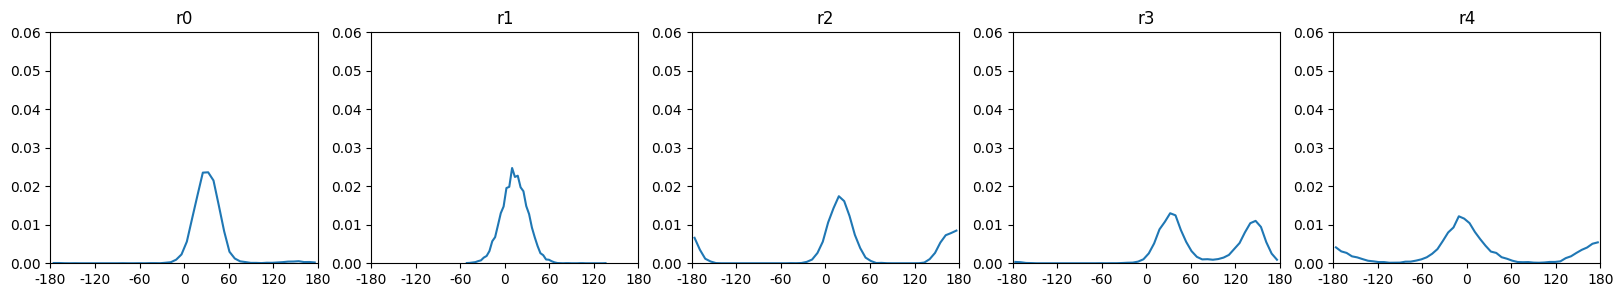

In [2]:
import matplotlib

fig_dump, ax_dump = plt.subplots(1,1)
fig_dump.set_size_inches(1,1)

fig, ax = plt.subplots(1, len(cmd_ps))
fig.set_size_inches(20, 3)

for rna_res_idx in range(len(cmd_ps)):
    hist = ax_dump.hist(cmd_ps[rna_res_idx], bins=50, density=True)
    hist_plot_y = hist[0]
    hist_plot_x = []
    for i in range(len(hist[1])-1):
        hist_plot_x.append((hist[1][i]+hist[1][i+1])/2)
    ax[rna_res_idx].plot(hist_plot_x, hist_plot_y)
    ax[rna_res_idx].set_title(f"r{rna_res_idx}")
    ax[rna_res_idx].set_xlim(-180, 180)
    ax[rna_res_idx].set_ylim(0, 0.06)
    ax[rna_res_idx].set_xticks([-180+val*60 for val in range(7)], [-180+val*60 for val in range(7)])
plt.close(fig_dump)

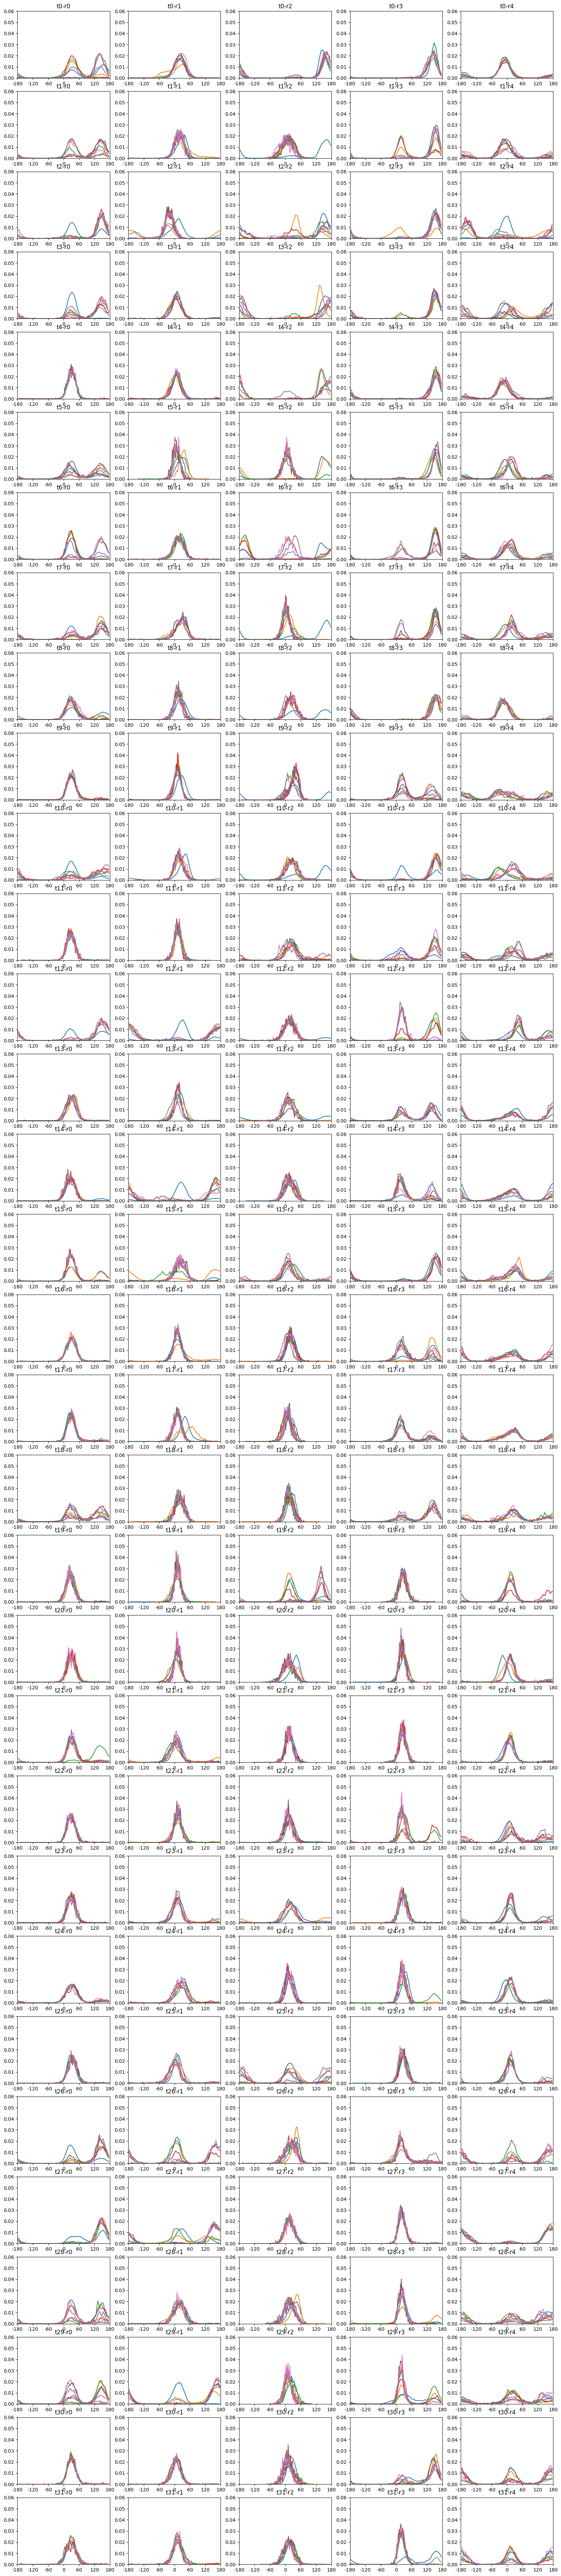

In [3]:
fig_dump, ax_dump = plt.subplots(1,1)
fig_dump.set_size_inches(1,1)

fig, ax = plt.subplots(len(pacs_ps), len(pacs_ps[0]))
fig.set_size_inches(20, 3*len(pacs_ps))


def bin_dist(com_dist):
    if com_dist < 2:
        return 0
    if com_dist < 2.5:
        return 1
    if com_dist < 3:
        return 2
    if com_dist < 3.5:
        return 3
    if com_dist < 4:
        return 4
    if com_dist < 4.5:
        return 5
    if com_dist < 5:
        return 6
    return 7
        

for trial in range(len(pacs_ps)):
    for rna_res_idx in range(len(pacs_ps[0])):
        ps_by_dist = [[] for _ in range(8)]
        for timestep in range(len(pacs_ps[trial][rna_res_idx])):
            p = pacs_ps[trial][rna_res_idx][timestep]
            com_dist = pacs_com_dists[trial][timestep]
            com_dist_bin = bin_dist(com_dist)
            ps_by_dist[com_dist_bin].append(p)

        for com_dist_bin, ps in enumerate(ps_by_dist):
            if len(ps) < 100:
                continue
            hist = ax_dump.hist(ps, bins=50, density=True)
            hist_plot_y = hist[0]
            hist_plot_x = []
            for i in range(len(hist[1])-1):
                hist_plot_x.append((hist[1][i]+hist[1][i+1])/2)
            ax[trial][rna_res_idx].plot(hist_plot_x, hist_plot_y, c=matplotlib.cm.tab10(com_dist_bin))
        
        ax[trial][rna_res_idx].set_title(f"t{trial}-r{rna_res_idx}")
        ax[trial][rna_res_idx].set_xlim(-180, 180)
        ax[trial][rna_res_idx].set_ylim(0, 0.06)
        ax[trial][rna_res_idx].set_xticks([-180+val*60 for val in range(7)], [-180+val*60 for val in range(7)])
plt.close(fig_dump)

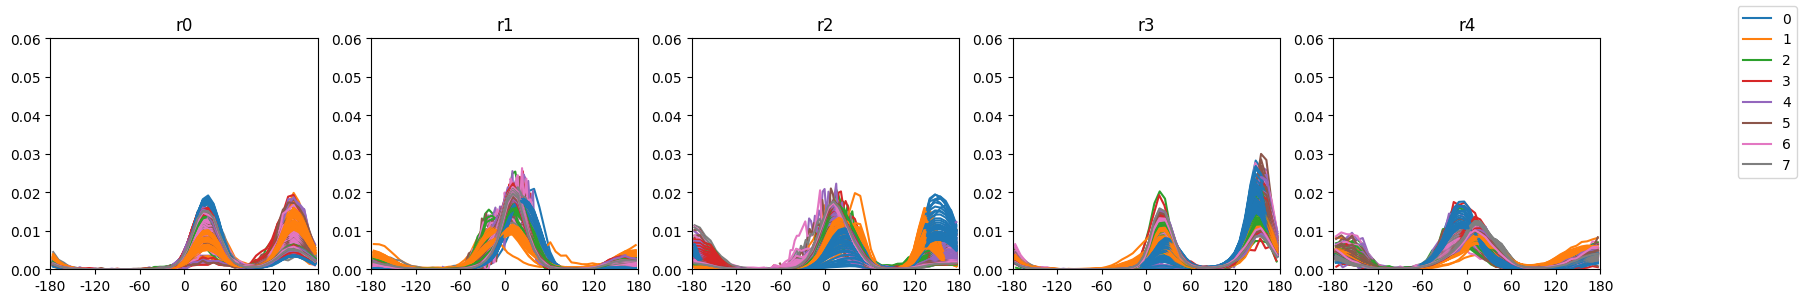

In [4]:
fig_dump, ax_dump = plt.subplots(1,1)
fig_dump.set_size_inches(1,1)

fig, ax = plt.subplots(1, len(pacs_ps[0]))
fig.set_size_inches(20, 3)

for rna_res_idx in range(len(pacs_ps[0])):
    ps_by_dist = [[] for _ in range(8)]
    for trial in range(1, len(pacs_ps)):
        for timestep in range(len(pacs_ps[trial][rna_res_idx])):
            p = pacs_ps[trial][rna_res_idx][timestep]
            com_dist = pacs_com_dists[trial][timestep]
            com_dist_bin = bin_dist(com_dist)
            ps_by_dist[com_dist_bin].append(p)

        for com_dist_bin, ps in enumerate(ps_by_dist):
            if len(ps) < 100:
                continue
            hist = ax_dump.hist(ps, bins=50, density=True)
            hist_plot_y = hist[0]
            hist_plot_x = []
            for i in range(len(hist[1])-1):
                hist_plot_x.append((hist[1][i]+hist[1][i+1])/2)
            label = ""
            if trial == 1 and rna_res_idx == 0:
                label = com_dist_bin
            ax[rna_res_idx].plot(hist_plot_x, hist_plot_y, c=matplotlib.cm.tab10(com_dist_bin), label=label)
        
    ax[rna_res_idx].set_title(f"r{rna_res_idx}")
    ax[rna_res_idx].set_xlim(-180, 180)
    ax[rna_res_idx].set_ylim(0, 0.06)
    ax[rna_res_idx].set_xticks([-180+val*60 for val in range(7)], [-180+val*60 for val in range(7)])
plt.close(fig_dump)
fig.legend()

0 1
(array([1.42075289e-03, 8.30252467e-04, 4.70131076e-04, 2.50111706e-04,
       1.35168851e-04, 6.41312066e-05, 3.60121391e-05, 2.91057015e-05,
       1.18396074e-05, 1.38128753e-05, 5.91980369e-06, 5.91980369e-06,
       4.43985277e-06, 6.41312066e-06, 7.39975461e-06, 9.86633948e-06,
       1.47995092e-05, 2.31858978e-05, 4.78517465e-05, 8.09039837e-05,
       1.36155485e-04, 2.53071608e-04, 4.92823657e-04, 1.06803125e-03,
       2.40146703e-03, 4.97066183e-03, 8.70063147e-03, 1.28997456e-02,
       1.60604274e-02, 1.65409181e-02, 1.48226951e-02, 1.13285310e-02,
       7.07959189e-03, 3.76450183e-03, 1.86276489e-03, 1.07296442e-03,
       7.49841800e-04, 5.73234324e-04, 5.95433588e-04, 7.21229416e-04,
       9.31875764e-04, 1.39559372e-03, 2.14198230e-03, 3.03488602e-03,
       3.86267191e-03, 4.43047974e-03, 4.40877380e-03, 3.83948601e-03,
       3.09013753e-03, 2.19082068e-03]), array([-1.79999922e+02, -1.72799950e+02, -1.65599979e+02, -1.58400008e+02,
       -1.51200037e+02, -1.

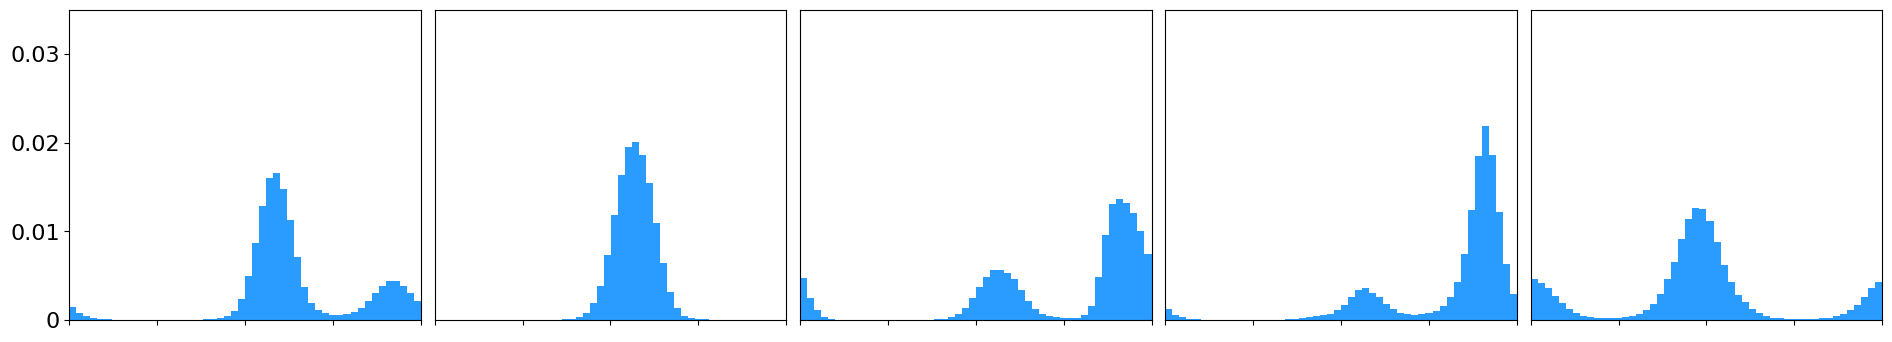

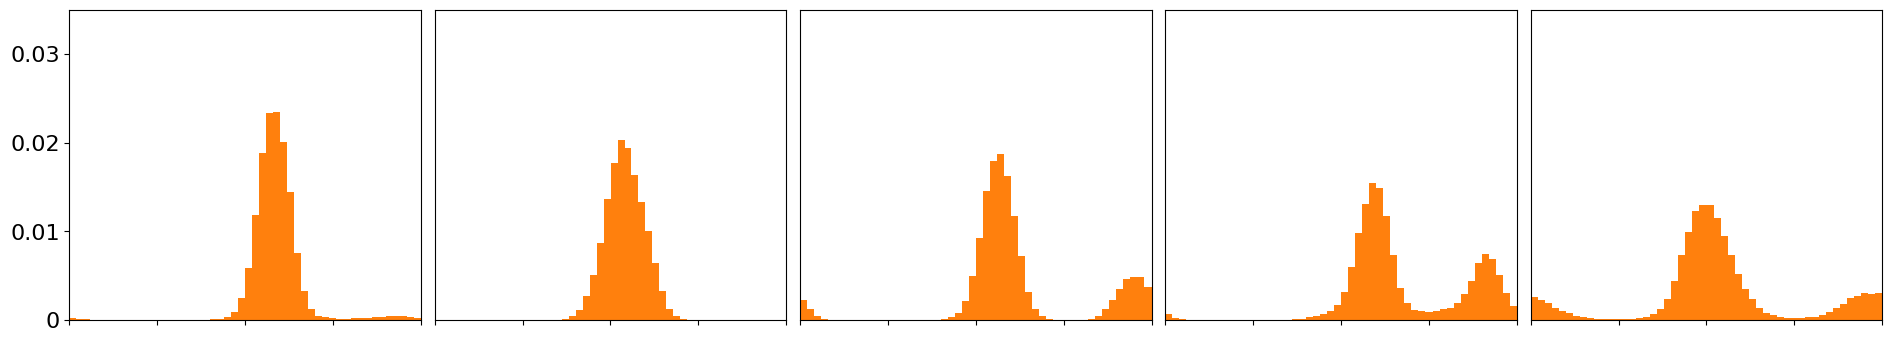

In [5]:
unstable_trials = [19,18,30,26,29,25,17,23,20,28,3,22,24,21,4,31,16,11,7,2,5,15,9,8,1,10,12,27,13,14,6,0][:13]
stable_trials = [val for val in range(32) if not val in unstable_trials]

all_stable_ps = []
all_unstable_ps = []
for rna_res_idx in range(5):
    stable_ps = [[] for _ in range(8)]
    unstable_ps = [[] for _ in range(8)]
    for trial in range(len(pacs_ps)):
        for timestep in range(len(pacs_ps[trial][rna_res_idx])):
            dist_idx = 0
            com_dist = pacs_com_dists[trial][timestep]
            if com_dist < 1.5:
                dist_idx = 0
            elif com_dist < 2:
                dist_idx = 1
            else:
                dist_idx = 2
            if trial in stable_trials:
                stable_ps[dist_idx].append(pacs_ps[trial][rna_res_idx][timestep])
            else:
                unstable_ps[dist_idx].append(pacs_ps[trial][rna_res_idx][timestep])
    all_stable_ps.append(stable_ps)
    all_unstable_ps.append(unstable_ps)

for dist_idx in range(1):
    fig1, ax1 = plt.subplots(1, 5)
    fig1.set_size_inches(19, 3.5)
    for rna_res_idx in range(5):
        stable_ps = all_stable_ps[rna_res_idx]
        print(rna_res_idx, 1)
        hist = ax1[rna_res_idx].hist(stable_ps[dist_idx], bins=50, density=True, color="#2A9BFF")
        print(hist)
        for i in range(1,49):
            if hist[0][i-1] < hist[0][i] and hist[0][i] > hist[0][i+1]:
                print("PEAK", i, hist[0][i], np.average([hist[1][i], hist[1][i+1]]))
        average = np.average(stable_ps[dist_idx])
        ax1[rna_res_idx].set_xlim(-180, 180)
        ax1[rna_res_idx].set_ylim(0, 0.035)
        xticks = [-180, -90, 0, 90, 180]
        ax1[rna_res_idx].set_xticks(xticks, ["" for val in range(len(xticks))])
        # ax1[rna_res_idx-1].set_xticks([-180+val*60 for val in range(7)], ["" for val in range(7)])
        ax1[rna_res_idx].set_yticks([val*0.01 for val in range(4)], [val*0.01 for val in range(4)])
        if rna_res_idx != 0:
            ax1[rna_res_idx].set_yticks([])
        ax1[0].set_yticks([0, 0.01, 0.02, 0.03], [0, 0.01, 0.02, 0.03], fontsize=16)
    fig1.tight_layout(pad=1, w_pad=1, h_pad=0.5)
    fig2, ax2 = plt.subplots(1, 5)
    fig2.set_size_inches(19, 3.5)
    for rna_res_idx in range(5):
        unstable_ps = all_unstable_ps[rna_res_idx]
        print(rna_res_idx, 2)
        hist = ax2[rna_res_idx].hist(unstable_ps[dist_idx], bins=50, density=True, color="#FF800D")
        print(hist)
        for i in range(1,49):
            if hist[0][i-1] < hist[0][i] and hist[0][i] > hist[0][i+1]:
                print("PEAK", i, hist[0][i], np.average([hist[1][i], hist[1][i+1]]))
        average = np.average(unstable_ps[dist_idx])
        ax2[rna_res_idx].set_xlim(-180, 180)
        ax2[rna_res_idx].set_ylim(0, 0.035)
        ax2[rna_res_idx].set_xticks([-180+val*60 for val in range(7)], [-180+val*60 for val in range(7)])
        ax2[rna_res_idx].set_xticks(xticks, ["" for val in range(len(xticks))])
        ax2[rna_res_idx].set_yticks([val*0.01 for val in range(4)], [val*0.01 for val in range(4)])
        if rna_res_idx != 0:
            ax2[rna_res_idx].set_yticks([])
        ax2[0].set_yticks([0, 0.01, 0.02, 0.03], [0, 0.01, 0.02, 0.03], fontsize=16)
    fig2.tight_layout(pad=1, w_pad=1, h_pad=0.5)